In [ ]:
!pip install sentence_transformers umap hdbscan wordcloud nltk gensim pyldavis spacy bertopic openai
import pandas as pd
import openai
from bertopic.representation import OpenAI
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
from umap import UMAP
from hdbscan import HDBSCAN
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import spacy
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
nltk.download('stopwords')

In [30]:
class TopicModeling():


  def __init__(self,df):
    self.df = df

  def head(self):
    """
    Print first 5 values of dataframe.
    """
    return self.df.head()

  def eda(self):
    """
    Perform some preliminary analysis on the dataframe.

    return: number of songs per album, length of lyrics,
    and histogram showing distribution of lyric character
    length.
    """
    print(self.df['Album'].value_counts())
    print('')
    print("Number of songs: ", len(self.df['Lyric']))
    num_char = sns.histplot(self.df['Lyric'].str.len())
    print('')
    num_nan = print("Number of missing values: ",self.df.isnull().sum().sum())
    num_nan_loc = self.df.isna().sum()
    return num_char, num_nan, num_nan_loc


  def stop_combine(self, stop1, stop2):
    """
    Combine stopword lists from different libraries for
    processing in BERTopic model.

    param1: stopword list 1
    param2: stopwords list 2
    return: combined stopword list
    """
    stop_words = set(stop1) | set(stop2)
    stop_words = list(stop_words)
    newStopWords = ['bring', 'yeah', 'let', 'oh', 'like', 'let', 'i\'m','i\'ll',
                    'i\'ve','got', 'khalid']
    stop_words.extend(newStopWords)
    return stop_words

  def corpus(self):
    """
    Creates a corpus of text from the 'Lyric' column for
    further exploratory analysis.

    return: corpus
    """
    corpus = []
    lyr_words = self.df['Lyric'].str.split()
    lyr_words = lyr_words.values.tolist()
    corpus = [word for i in lyr_words for word in i]
    return corpus

  def most_common_words(self, corpus, stop):
    """
    Creates a plot of the most common words in corpus.

    param1: corpus of text
    param2: stopwords list
    return: plot of most common words in corpus
    """
    counter = collections.Counter(corpus)
    most_common = counter.most_common()
    x, y = [], []
    for word,count in most_common[:60]:
      if (word not in stop):
        x.append(word)
        y.append(count)
    common_plot = sns.barplot(x=y,y=x)
    return common_plot

  def generate_WC(self, stopwords):
    """
    Generate a wordcloud from 'Lyric' column

    param: stopwords list
    return: wordcloud
    """
    wordcloud = WordCloud(
        background_color='white',
        stopwords = stopwords,
        max_words=60,
        max_font_size=30,
        scale = 3
    )
    wordcloud = wordcloud.generate(self.df['Lyric'].str.cat(sep=' '))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

  def col_tolist(self):
    """
    Converts dataframe column to list for BERTopic modeling

    returns: list
    """
    lyr_list = self.df['Lyric'].tolist()
    return lyr_list

  def bert_model_inst(self, stopwords):
    """
    Create a BERTopic object with set parameters to
    call upon.

    param: stopwords list
    return: BERTopic model object
    """
    vec_model = CountVectorizer(stop_words=stopwords)
    embedding_model = SentenceTransformer('all-mpnet-base-v2')
    ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)
    hdbscan_model = HDBSCAN(min_cluster_size=2, metric='euclidean',
                            cluster_selection_method='eom',
                            prediction_data=True)
    umap_model = UMAP(n_neighbors=2,
                      metric='cosine', low_memory=False)

    main_representation = KeyBERTInspired()
    aspect_model2 = PartOfSpeech("en_core_web_sm")
    client = openai.OpenAI(api_key="sk-...")
    aspect_model1 = OpenAI(client, model="gpt-3.5-turbo", chat=True)

    representation_model = {
    "Main":main_representation,
    "Aspect1":aspect_model1,
    "Aspect2":aspect_model2}

    model = BERTopic(
       hdbscan_model=hdbscan_model,
       vectorizer_model = vec_model,
       embedding_model = embedding_model,
       ctfidf_model = ctfidf_model,
       representation_model = representation_model,
       umap_model = umap_model,
       calculate_probabilities=True,
       verbose=True)
    return model

  def bert_model(self, model, lyr_list):
    """
    Fit and transform a provided list to BERTopic model.

    param1: BERTopic model object
    param2: list
    return: generated topics, their probabilities, and
    transformed model
    """
    topics, probs = model.fit_transform(lyr_list)
    return topics, probs, model

  def get_single_list(self):
    """
    Get a list of albums that only have one song.

    return: list
    """
    df_group = self.df.groupby('Album')
    single_list = list()
    for Album_Name, DataFrame in df_group:
      if DataFrame.shape[0] == 1:
        single_list.append(Album_Name)
    return single_list

  def get_lyr_lists(self, single_list):
    """
    Replace NaN and single album values with 'Single', drop entries
    that do not have lyrics published yet, and generate a dictionary
    that maps a list of songs within an album to the album name.

    param: list of singles albums
    return: dictionary
    """
    clean_df = self.df
    clean_df = clean_df.drop(clean_df[clean_df['Lyric'].str.len() < 95].index)
    df_group = clean_df.groupby('Album')
    clean_df['Album'].fillna('Single', inplace=True)
    for single in single_list:
      clean_df.replace(single, 'Single', inplace=True)
    lyric_dict = {}
    for Album_Name, Data_Frame in df_group:
      lyric_dict[Album_Name] = list(Data_Frame['Lyric'])
    return lyric_dict

  def topic_interpretation(self, topic_list):
    """
    Call on OpenAI API to take in the list of words generated in a
    topic and provide a description encapsulating the overarching theme.

    param: list of topic words
    return: description
    """
    openai.api_key = "sk-..."
    client = openai.OpenAI(api_key=openai.api_key)

    prompt = f"Based on the following words from song lyrics, what would be an appropriate topic? {', '.join(topic_list)}."
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ]
    )

    return(response.choices[0].message.content)

In [31]:
df = TopicModeling(pd.read_csv('Khalid.csv'))
df.head()

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0,Khalid,Young Dumb & Broke,American Teen,2017.0,2017-03-03,so you're still thinking of me just like i kno...
1,1,Khalid,Location,American Teen,2016.0,2016-04-30,send me your location let's focus on communica...
2,2,Khalid,Better,Suncity,2018.0,2018-09-14,better nothing baby nothing feels better i'm n...
3,3,Khalid,Talk,Free Spirit,2019.0,2019-02-07,can we just talk can we just talk talk about w...
4,4,Khalid,Saved,American Teen,2017.0,2017-01-13,4 the hard part always seems to last forever...


Album
American Teen                                   15
Free Spirit                                     14
Suncity                                          7
K3*                                              4
So Fresh: The Hits of Spring 2019                1
American Teen: Music From the Motion Picture     1
The Uncle Drew Motion Picture Soundtrack         1
The Annual 2020                                  1
Name: count, dtype: int64

Number of songs:  64

Number of missing values:  28


(None,
 Unnamed: 0     0
 Artist         0
 Title          0
 Album         20
 Year           4
 Date           4
 Lyric          0
 dtype: int64)

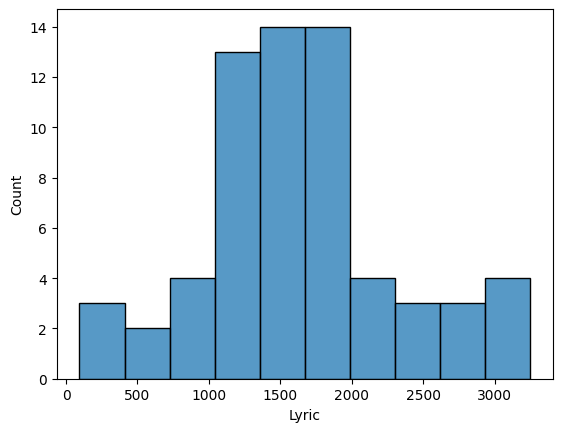

In [ ]:
df.eda()

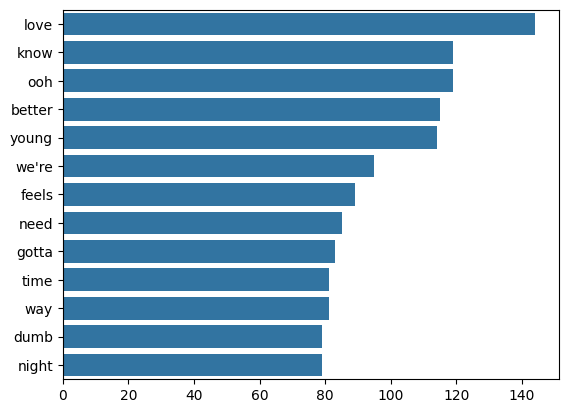

In [4]:
corpus = df.corpus()
stop1 = stopwords.words('english')
en = spacy.load('en_core_web_sm')
stop2 = en.Defaults.stop_words
stopwords = df.stop_combine(stop1, stop2)
most_common = df.most_common_words(corpus, stopwords)

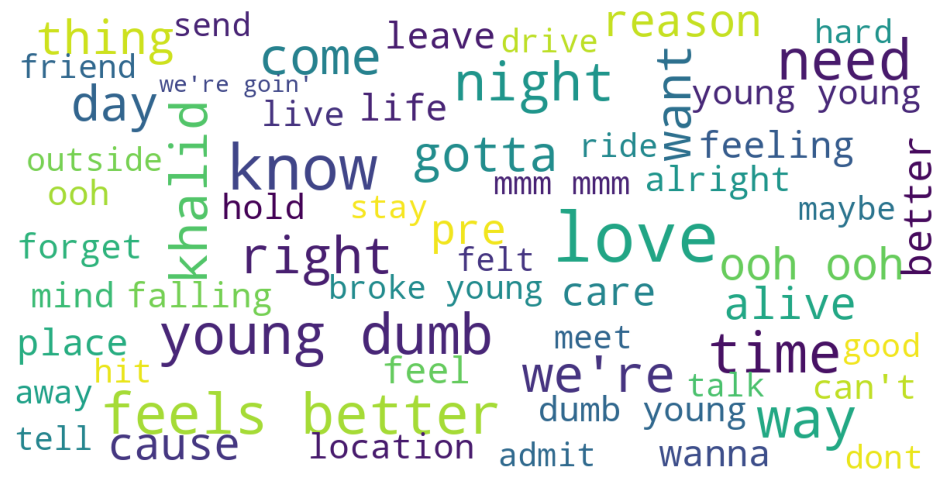

In [ ]:
wc_stop = set(STOPWORDS)
df.generate_WC(stopwords)

In [ ]:
lyr_list = df.col_tolist()
bert_model = df.bert_model_inst(stopwords)
topics, probs, model = df.bert_model(bert_model,lyr_list)

In [ ]:
model.get_topic_info()

In [17]:
openai_call1 = model.get_topic_info()['Representation'][1]
representation_call = model.get_topic_info()['Aspect1'][1]

In [ ]:
print(openai_call1)

In [ ]:
response = df.topic_interpretation(openai_call1)
print(response)

In [ ]:
print(representation_call)

In [ ]:
model.visualize_documents(lyr_list)

In [32]:
hierarchical_topics = model.hierarchical_topics(lyr_list)

100%|██████████| 10/10 [01:26<00:00,  8.63s/it]


In [33]:
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
model.visualize_topics()

In [35]:
model.visualize_heatmap()

In [34]:
model.visualize_barchart()

In [28]:
single_list = df.get_single_list()
lyr_dict = df.get_lyr_lists(single_list)
singles_lyr = lyr_dict['Single']

In [32]:
bert_model_1 = df.bert_model_inst(stopwords)
topics1, probs1, model1 = df.bert_model(bert_model_1,singles_lyr)

2024-04-03 04:57:02,456 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-04-03 04:57:36,088 - BERTopic - Embedding - Completed ✓
2024-04-03 04:57:36,094 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-03 04:57:39,601 - BERTopic - Dimensionality - Completed ✓
2024-04-03 04:57:39,603 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-03 04:57:39,615 - BERTopic - Cluster - Completed ✓
2024-04-03 04:57:39,620 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
2024-04-03 04:58:19,888 - BERTopic - Representation - Completed ✓


In [33]:
model1.get_topic_info()

,Topic,Count,Name,Representation,Aspect1,Aspect2,Representative_Docs
0,0,7,0_vivendo_goodbye_para_tryna,"[vivendo, goodbye, para, tryna, motivo, wanna,...",[love and longing in music],"[reason, day, way, olhos, drive, night, hard, ...",[será que é melhor apenas acreditar nas teoria...
1,1,5,1_remix_refrain_communicating_lil,"[remix, refrain, communicating, lil, wanna, se...",[Location Communication Remix],"[talk, location, ride, place, vibrations, new,...",[little simz uh it's a win baby feels like som...
2,2,5,2_lil_commitment_boogie_trouble,"[lil, commitment, boogie, trouble, love, yacht...",[Young Dumb and Broke High School Kids' Relati...,"[young, dumb, broke, right, high, school, time...",[a boogie wit da hoodie ooh a boogie wit da ...
3,3,5,3_rihanna_babygirl_night_street,"[rihanna, babygirl, night, street, way, better...",[Romantic Night Stories with Rihanna's Music],"[better, feeling, fast, car, girl, night, drop...",[i'm not really drunk i never get that fucked ...


In [34]:
model1.visualize_barchart()